# 사용API호출과 데이터 불러오기.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
import scipy as sp


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 데이터 확인과 칼럼정리

In [2]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
del train['id']

In [6]:
print(train.columns)
#데이터 타입 확인
train.info()
train.head()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


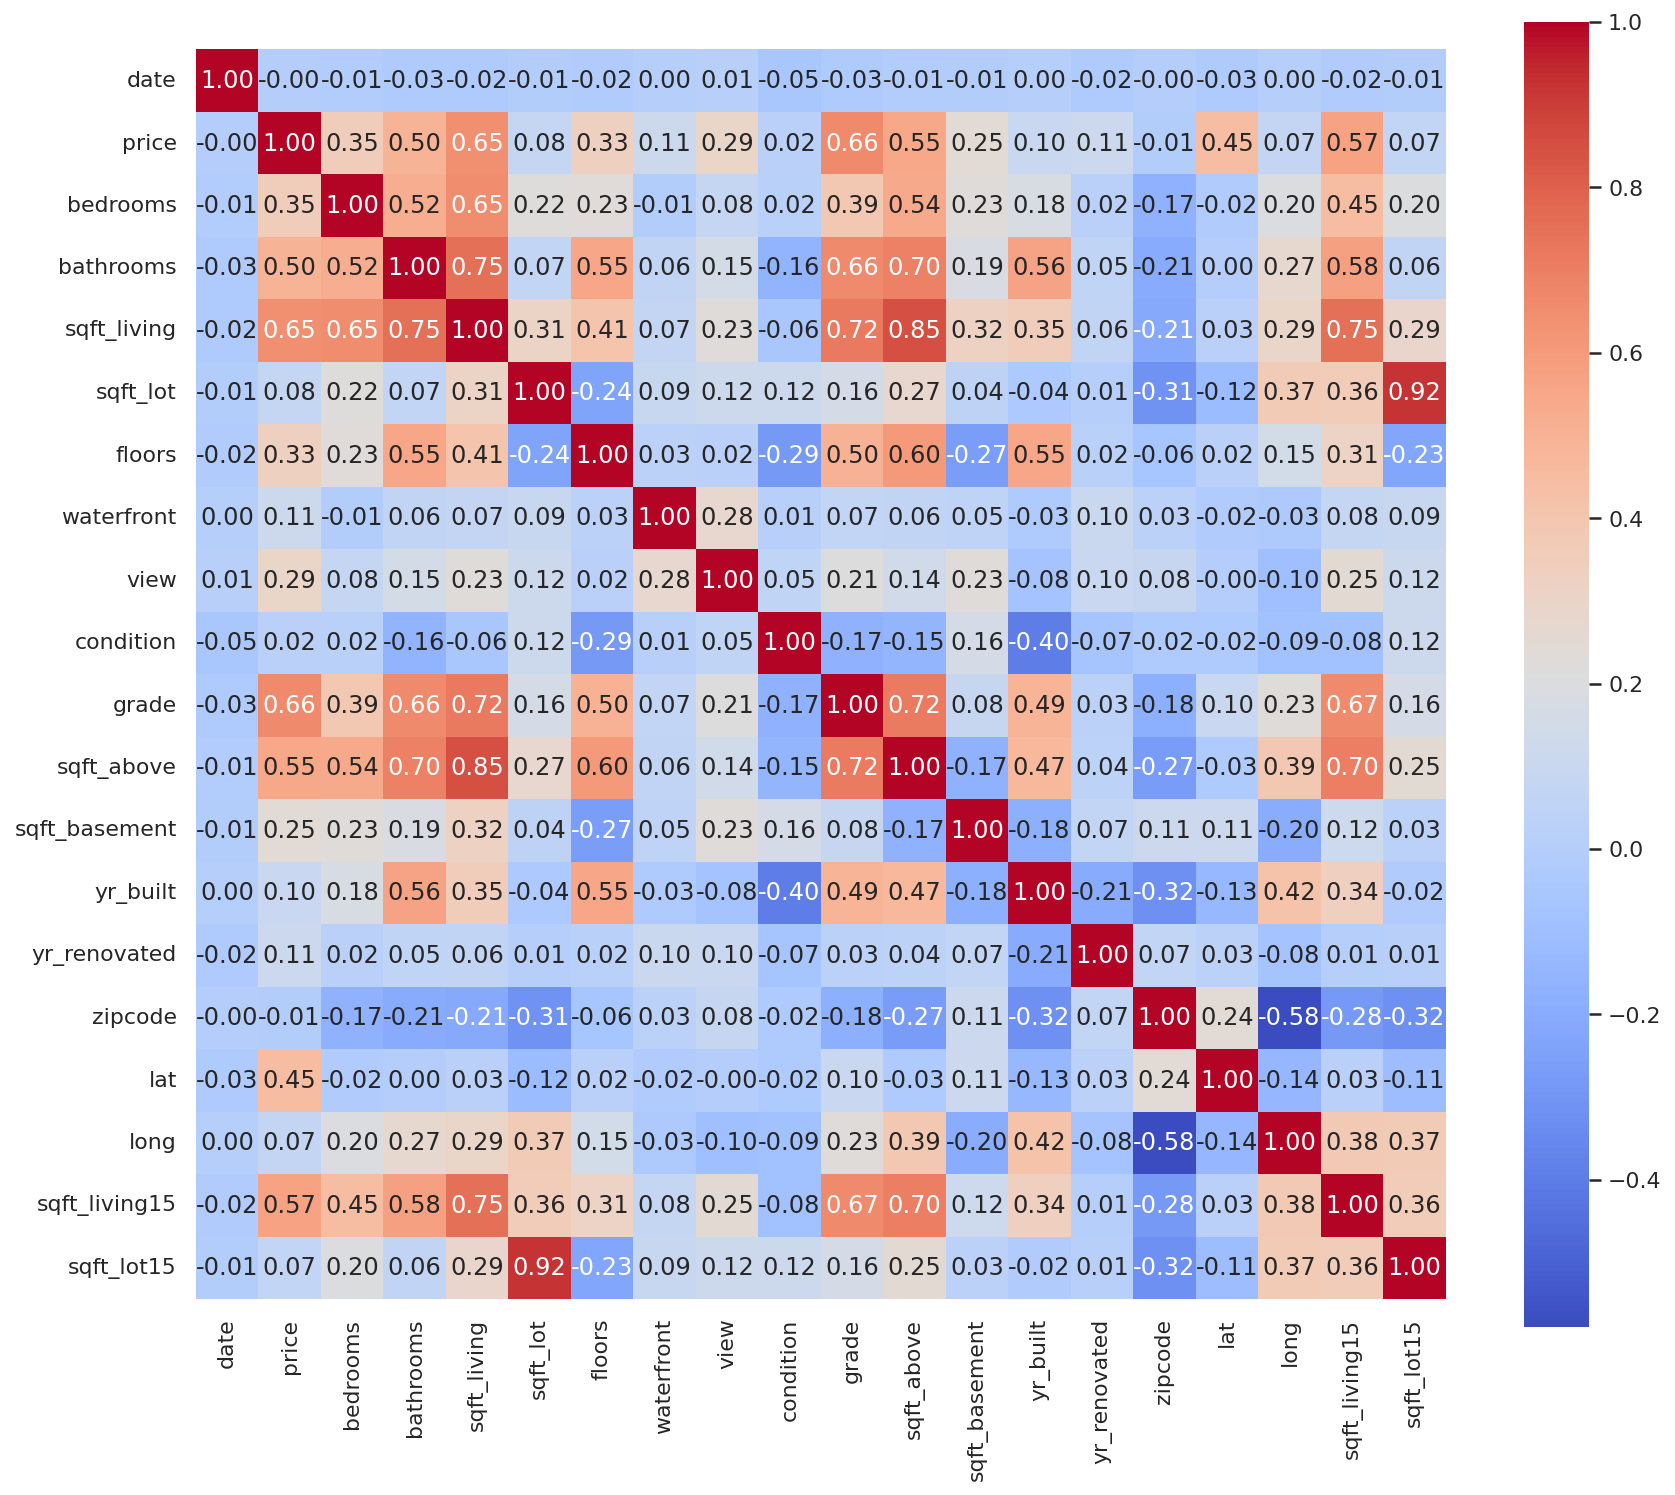

열 이름: ['date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'waterfront' 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement'
 'yr_built' 'yr_renovated' 'zipcode' 'lat' 'long' 'sqft_living15'
 'sqft_lot15']


In [7]:

# 스피어만 상관관계 계산
cor = train.corr(method='spearman')

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.0)
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 열 이름 출력
print("열 이름:", train.columns.values)

가격과 상관도가 떨어지는것들이 많아보입니다. 관련도가 높은 상위 10개의 칼럼을 제외하고 삭제해도 좋을것 같습니다.

In [8]:
# price와의 스피어만 상관관계 계산
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=11, columns='price').index

# price를 제외한 상위 10개의 피처만 남기기
train_filtered = train[cor_cols]

# 결과 출력
print("상위 10개 피처:")
print(cor_cols.values)

상위 10개 피처:
['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement']


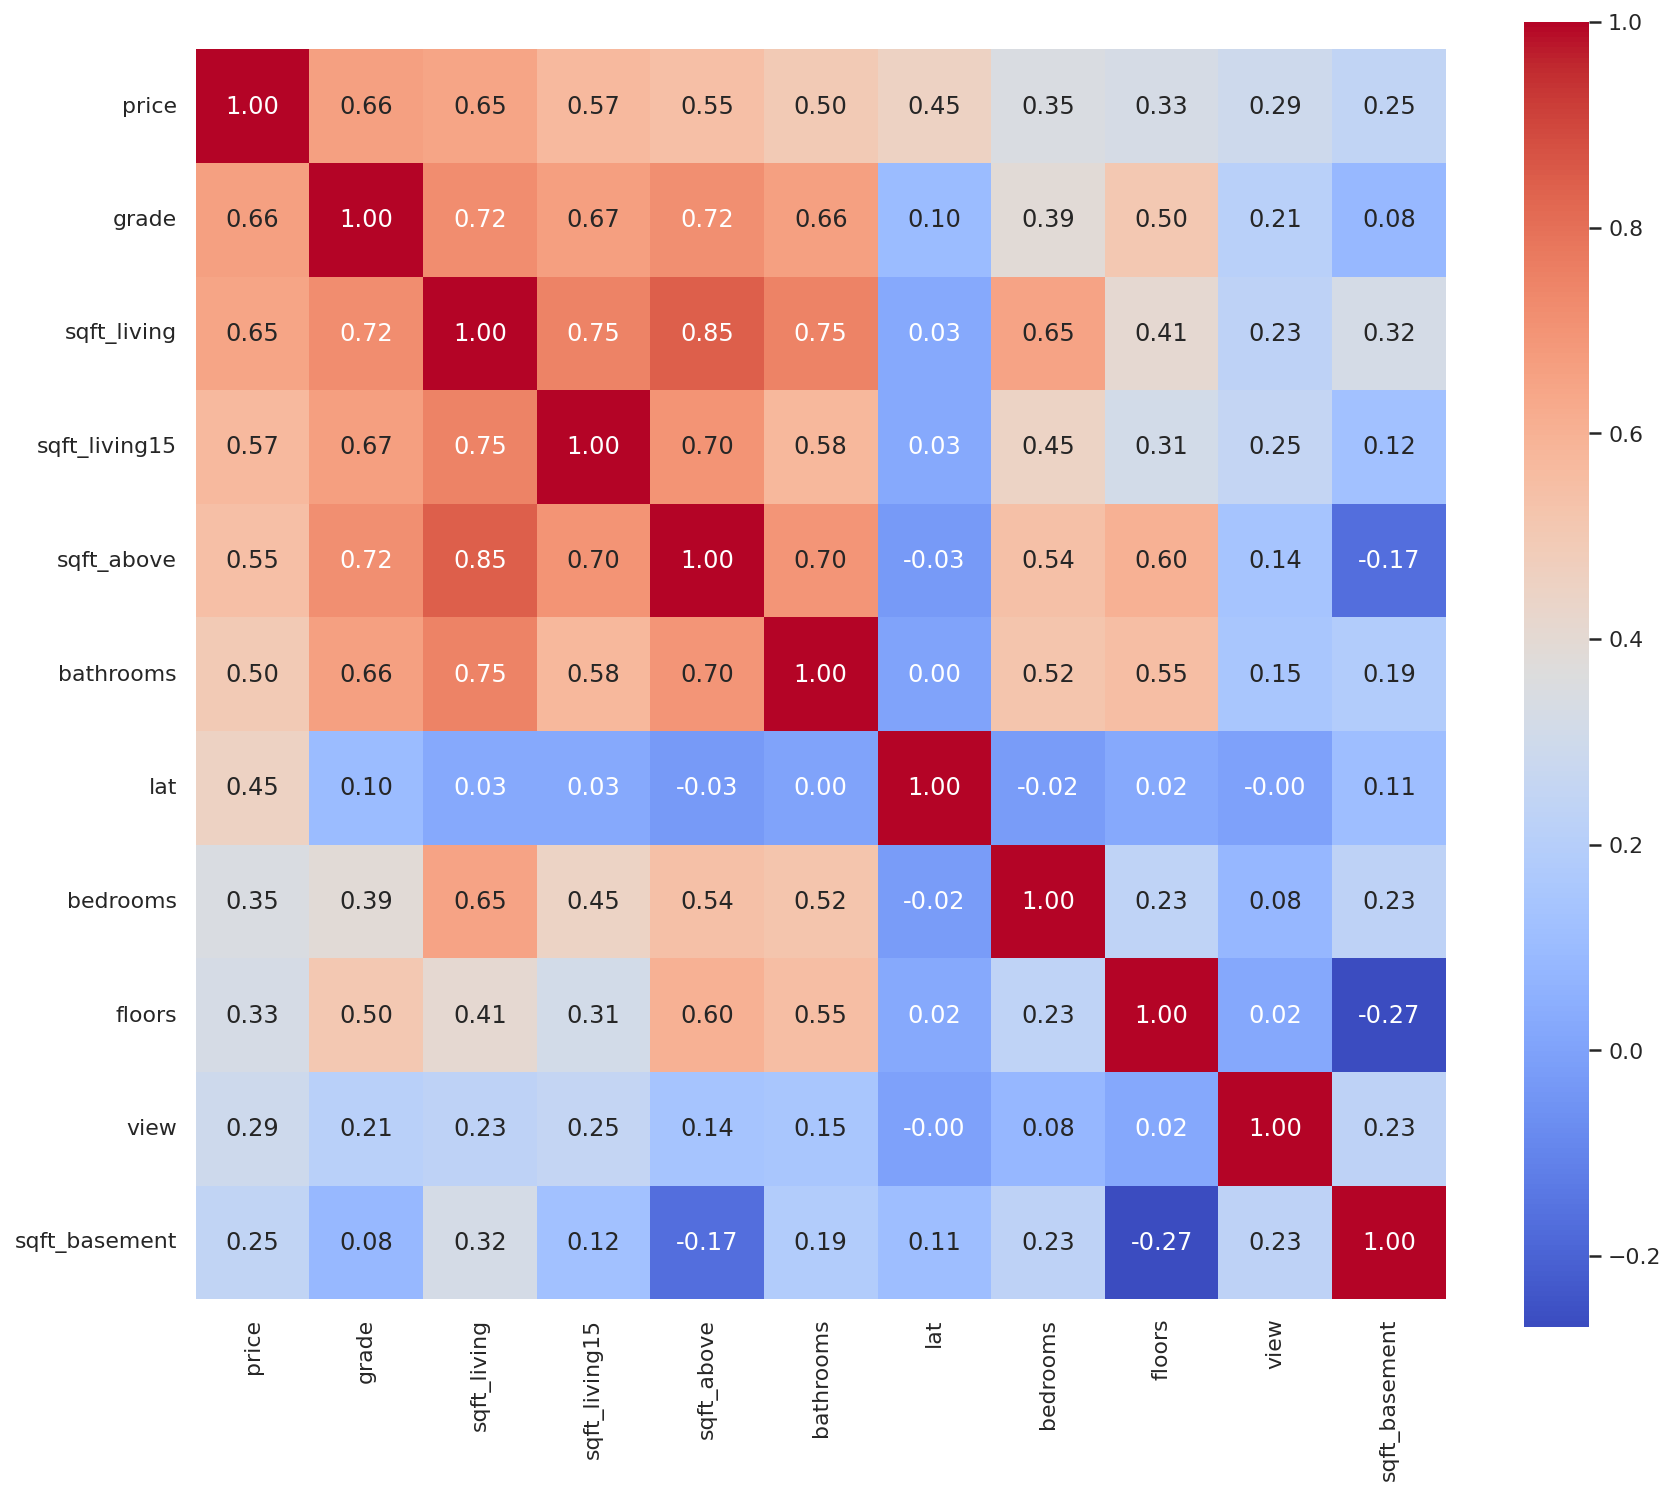

열 이름: ['date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'waterfront' 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement'
 'yr_built' 'yr_renovated' 'zipcode' 'lat' 'long' 'sqft_living15'
 'sqft_lot15']


In [9]:
# 스피어만 상관관계 계산
cor = train_filtered.corr(method='spearman')

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.0)
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# 열 이름 출력
print("열 이름:", train.columns.values)

In [12]:
train=train_filtered
columns_to_keep = ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view', 'sqft_basement']
test = test[columns_to_keep]
y = train['price']
del train['price']

print(train.columns)

Index(['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms',
       'lat', 'bedrooms', 'floors', 'view', 'sqft_basement'],
      dtype='object')


# 타겟값 시각화로 확인

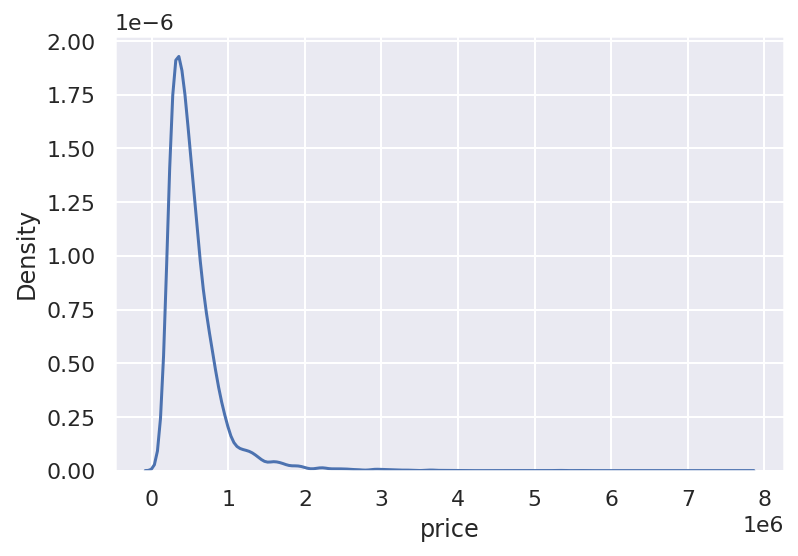

In [13]:
sns.kdeplot(y)
plt.show()

In [14]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

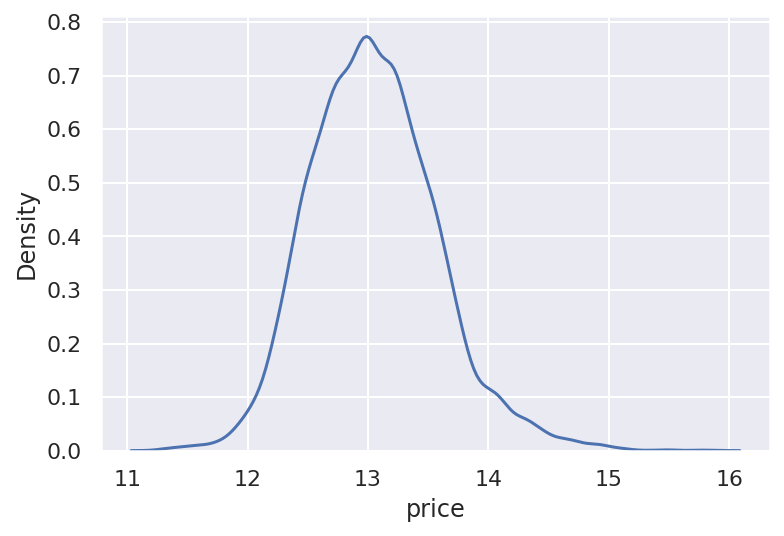

In [15]:
#로그함수로 정규분포로 변경

sns.kdeplot(y)
plt.show()

In [16]:
# 데이터 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grade          15035 non-null  int64  
 1   sqft_living    15035 non-null  int64  
 2   sqft_living15  15035 non-null  int64  
 3   sqft_above     15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   lat            15035 non-null  float64
 6   bedrooms       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   view           15035 non-null  int64  
 9   sqft_basement  15035 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 1.1 MB


In [17]:
#검증용 데이터셋 호출
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [19]:
#네 가지 모델 호출
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [20]:
#random_state 값을 특정 값으로 고정 random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
# 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있습니다.
print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)

GradientBoostingRegressor
XGBRegressor


In [22]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,165035.942418
GradientBoostingRegressor,162933.074181
LGBMRegressor,160075.441244
XGBRegressor,158804.010899


In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = {
    'n_estimators': [50,300],
    'max_depth': [1, 7],
}

In [25]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# rdforest 튜닝
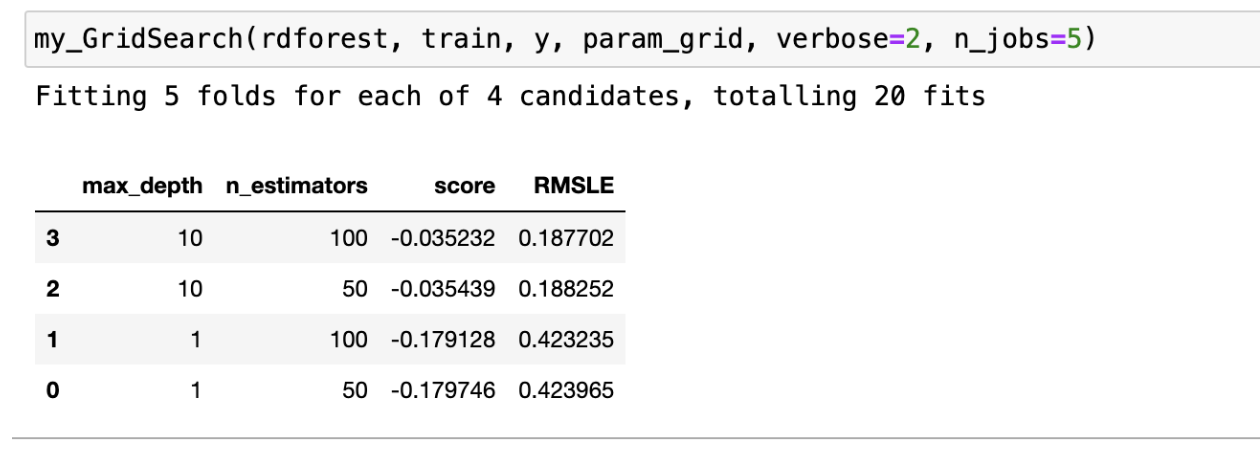
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1, 10]
}


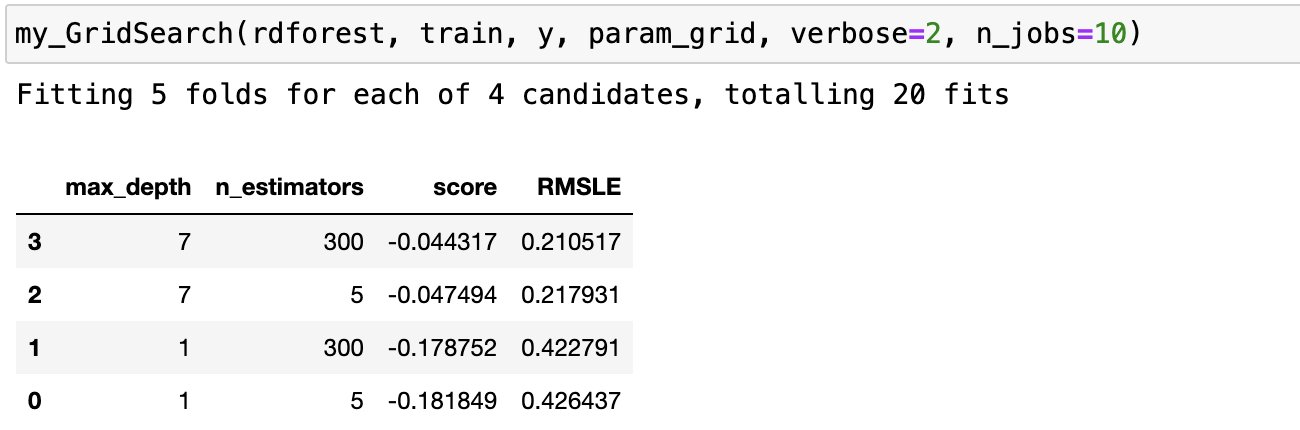
param_grid = {
    'n_estimators': [5,300],
    'max_depth': [1, 7],
}


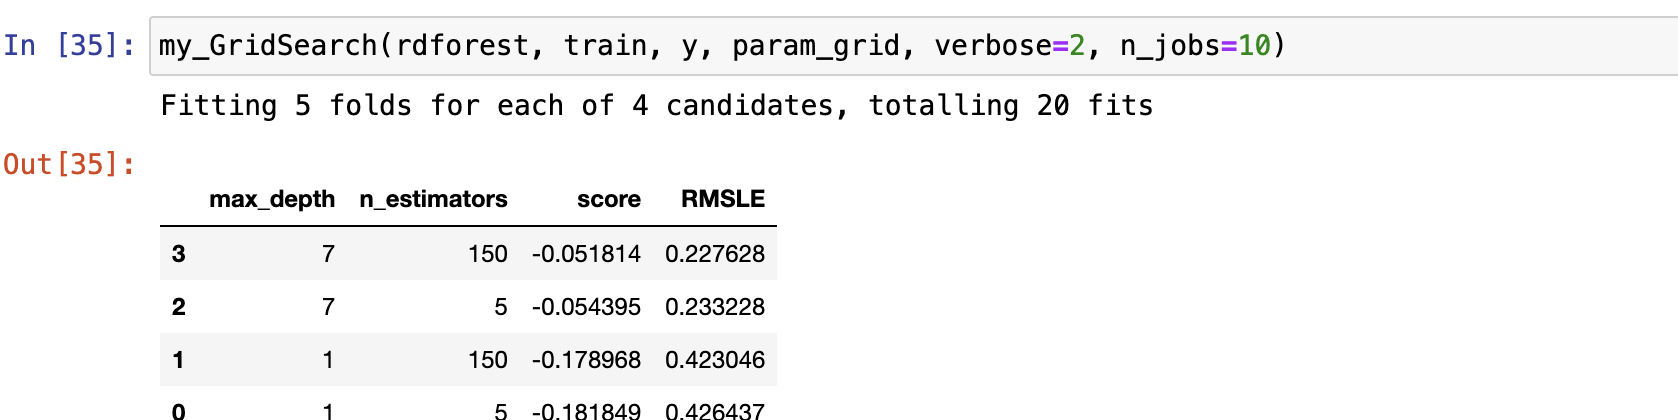
param_grid = {
    'n_estimators': [5,150],
    'max_depth': [1, 7],
}

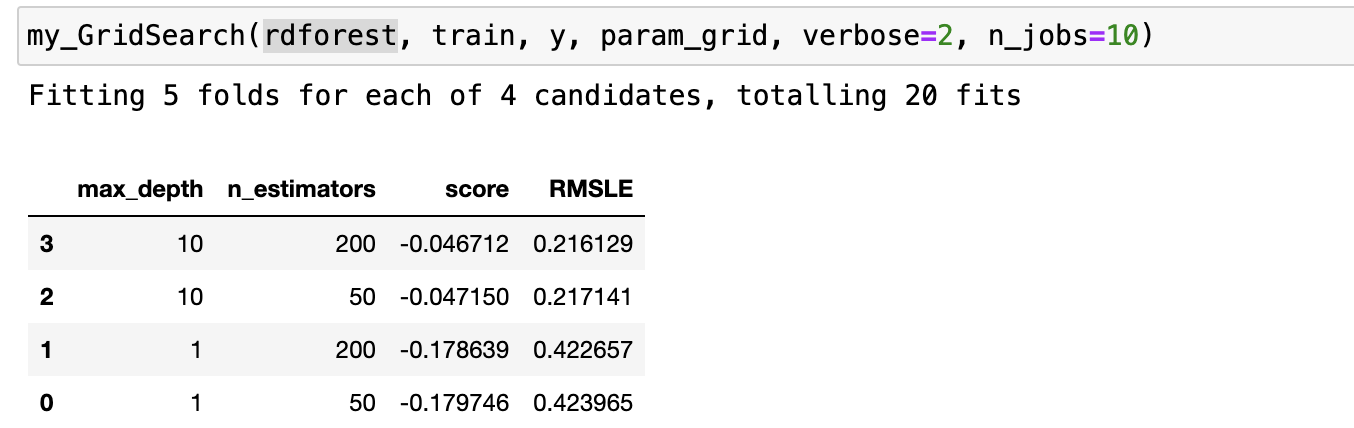
param_grid = {
    'n_estimators': [50,200],
    'max_depth': [1, 10],
}


# lightgbm 튜닝
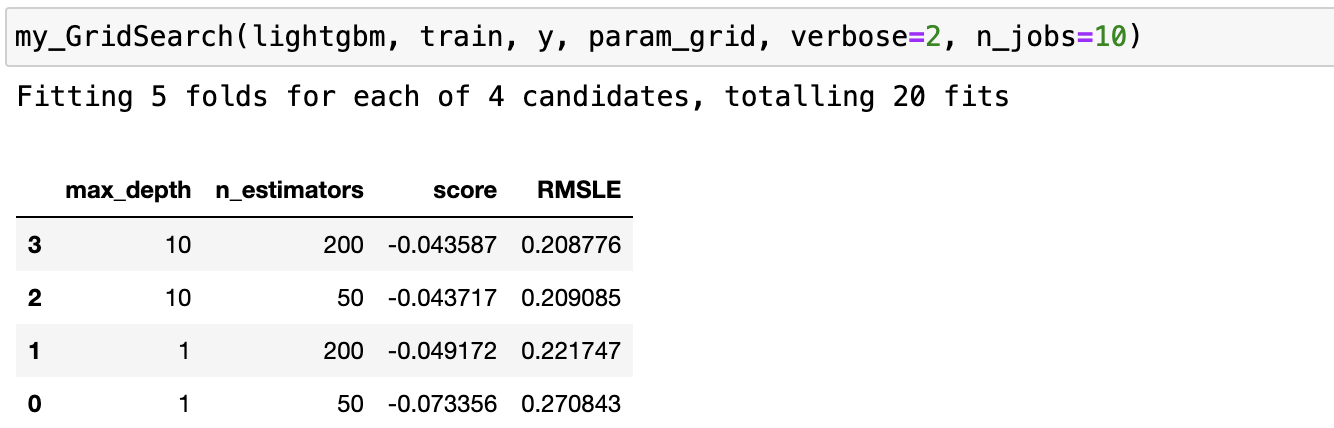
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1, 10],
}

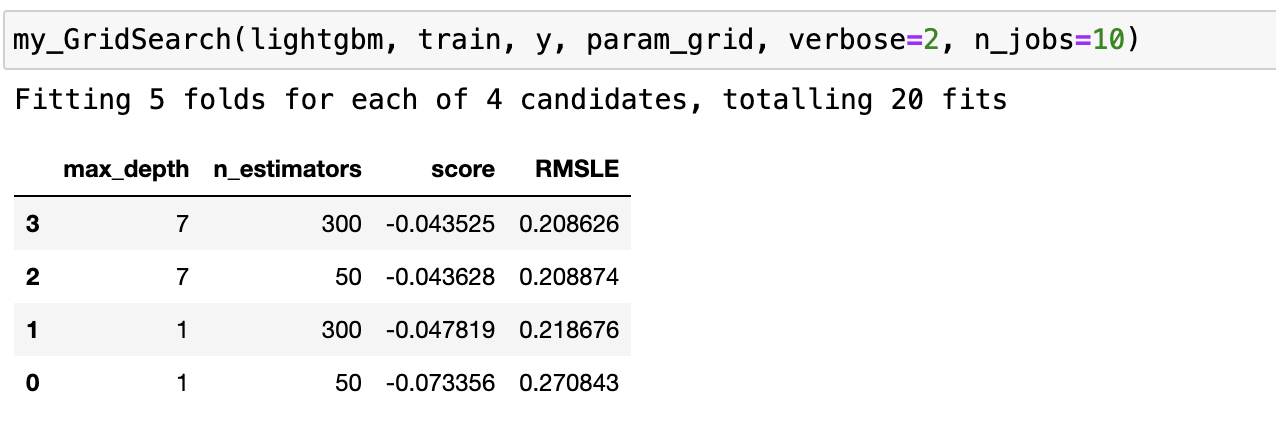
param_grid = {
    'n_estimators': [50,300],
    'max_depth': [1, 7],
}

In [26]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,7,300,-0.043525,0.208626
2,7,50,-0.043628,0.208874
1,1,300,-0.047819,0.218676
0,1,50,-0.073356,0.270843


In [29]:
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.11768887, 12.77778404, 14.52717424, ..., 12.92255632,
       12.69201555, 12.92910298])

In [32]:
predictions = np.expm1(prediction)
prediction

array([13.11768887, 12.77778404, 14.52717424, ..., 12.92255632,
       12.69201555, 12.92910298])

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,13.117689
1,15036,12.777784
2,15037,14.527174
3,15038,12.712490
4,15039,12.631879


In [35]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [36]:
save_submission(lightgbm, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.8s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.9s
[CV] END .......................max_depth=7, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=7, n_estimators=300; total time=   2.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.8s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.9s
[CV] END .......................max_depth=7, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=7, n_estimators=300; total time=   2.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ..................

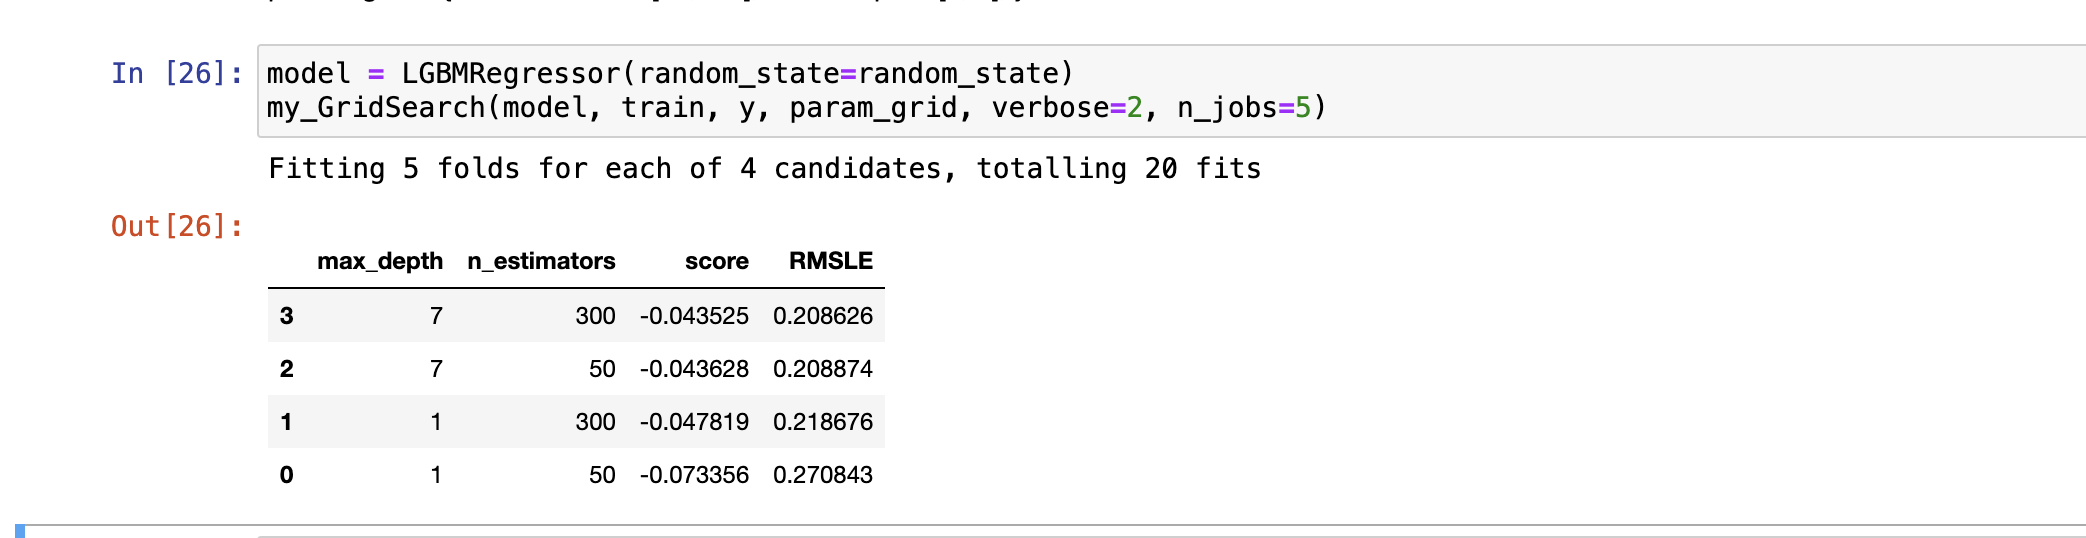

해당 상태의(상위칼럼 10개를 제외하고 전부 삭제하고,param_grid = {
    'n_estimators': [50,300],
    'max_depth': [1, 7],
}인 상태의 lightgbm을 사용한 점수

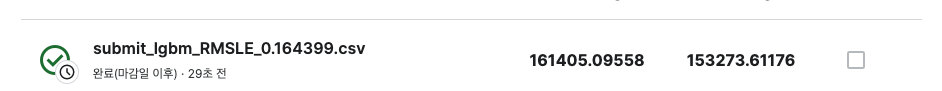
